<a href="https://colab.research.google.com/github/Series-Parallel/UCR_Time_Series_Classification_Deep_Learning_From_Scratch/blob/main/FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lightning > /dev/null

In [30]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks import Callback

from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

In [3]:
def reducer(filename):
  data = np.loadtxt(filename, delimiter=',')
  Y = data[:,0]
  X = data[:,1:]
  return X, Y

In [4]:
x_train, y_train = reducer("Adiac_TRAIN.txt")
x_test, y_test = reducer("Adiac_TEST.txt")

In [5]:
classes = len(np.unique(y_test))

In [6]:
y_train = ((y_train - y_train.min())/(y_train.max() - y_train.min()) * (classes - 1)).astype(int)
y_test = ((y_test - y_test.min())/ (y_test.max() - y_test.min()) * (classes - 1)).astype(int)

In [7]:
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [8]:
x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

In [9]:
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], 1)

In [10]:
input_train = torch.tensor(x_train, dtype=torch.float32)
input_test = torch.tensor(x_test, dtype=torch.float32)

In [11]:
train_dataset = TensorDataset(input_train, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [12]:
class FCN(L.LightningModule):

  def __init__(self, input_shape, num_classes):

    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=8, stride=1, padding='same')
    self.bn1 = nn.BatchNorm2d(128)

    self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding='same')
    self.bn2 = nn.BatchNorm2d(256)

    self.conv3 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding='same')
    self.bn3 = nn.BatchNorm2d(128)

    self.global_pool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(128, num_classes)

    self.loss = nn.CrossEntropyLoss()

  def forward(self, x):

    x = self.conv1(x)
    x = self.bn1(x)
    x = F.relu(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = F.relu(x)

    x = self.conv3(x)
    x = self.bn3(x)
    x = F.relu(x)

    self.last_conv_output = x.clone()

    x = self.global_pool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)

    return x

  def training_step(self, batch, batch_idx):
    inputs, labels = batch
    outputs = self.forward(inputs)
    loss = self.loss(outputs, labels)
    self.log('train_loss', loss)
    return loss

  def configure_optimizers(self):
    optimizer = Adam(self.parameters(), lr=0.001)
    return optimizer

In [13]:
input_shape = input_train.shape[1:]  # Should be (1, 1, time_series_length)
num_classes = len(torch.unique(y_train_tensor))


In [14]:

model = FCN(input_shape, num_classes)
trainer = L.Trainer(max_epochs=2000)
trainer.fit(model, train_dataloaders=train_dataloader)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: True, using: 8 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: True, using: 8 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as

Training: |          | 0/? [00:00<?, ?it/s]

In [15]:
model.eval()

FCN(
  (conv1): Conv2d(1, 128, kernel_size=(8, 8), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=37, bias=True)
  (loss): CrossEntropyLoss()
)

In [16]:
with torch.no_grad():
    logits = model(input_test[:100])
    probs = torch.softmax(logits, dim=1)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv2d(


In [17]:
last_conv = model.last_conv_output

In [22]:
last_conv = last_conv.squeeze(-1)

In [23]:
softmax_weights = model.fc.weight.data

In [25]:
print("Shape of last_conv before einsum:", last_conv.shape)
CAM = torch.einsum("bct,oc->bto", last_conv, softmax_weights)

Shape of last_conv before einsum: torch.Size([100, 128, 176])


In [26]:
CAM = CAM.numpy()

In [27]:
CAM = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True) + 1e-8)


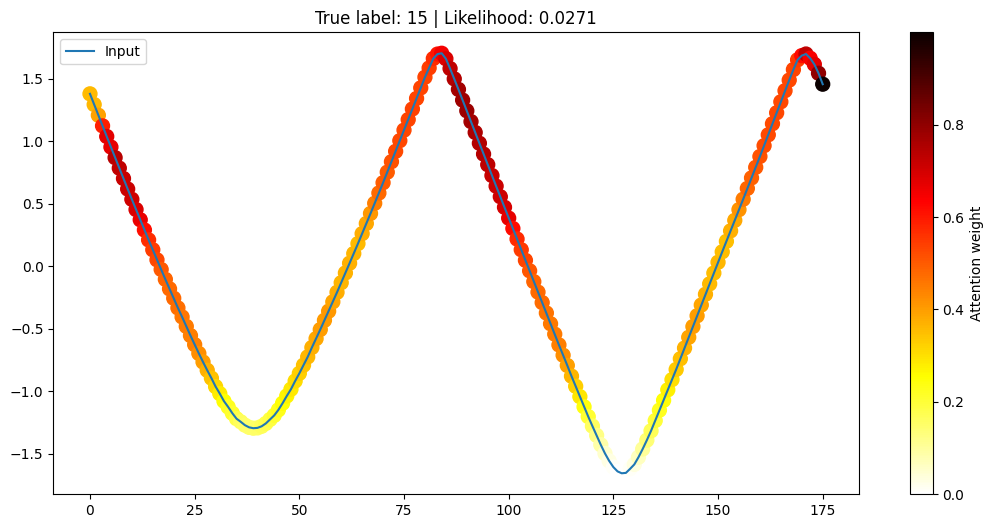

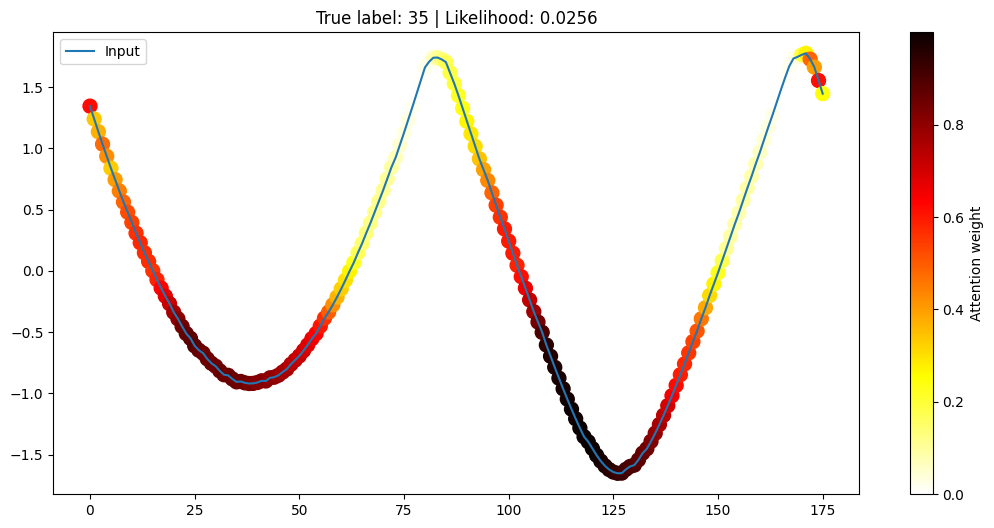

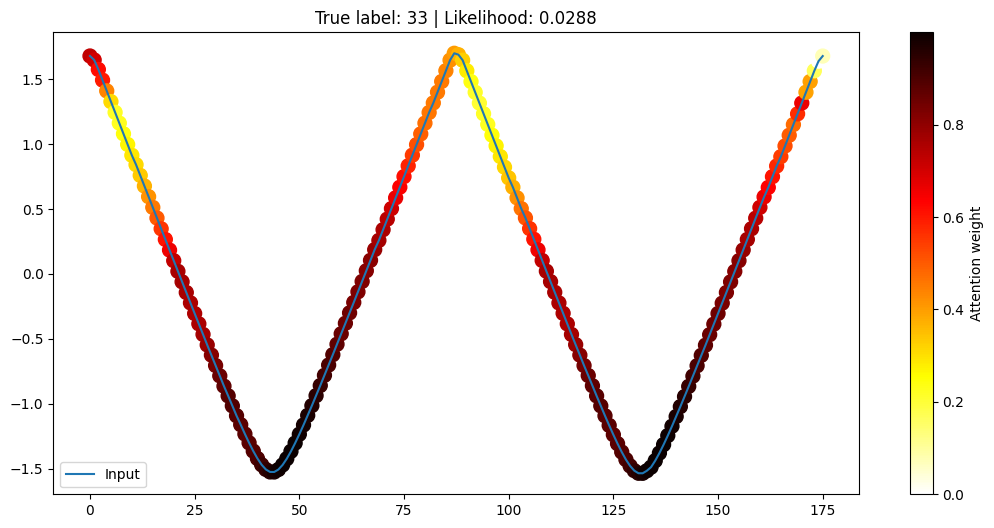

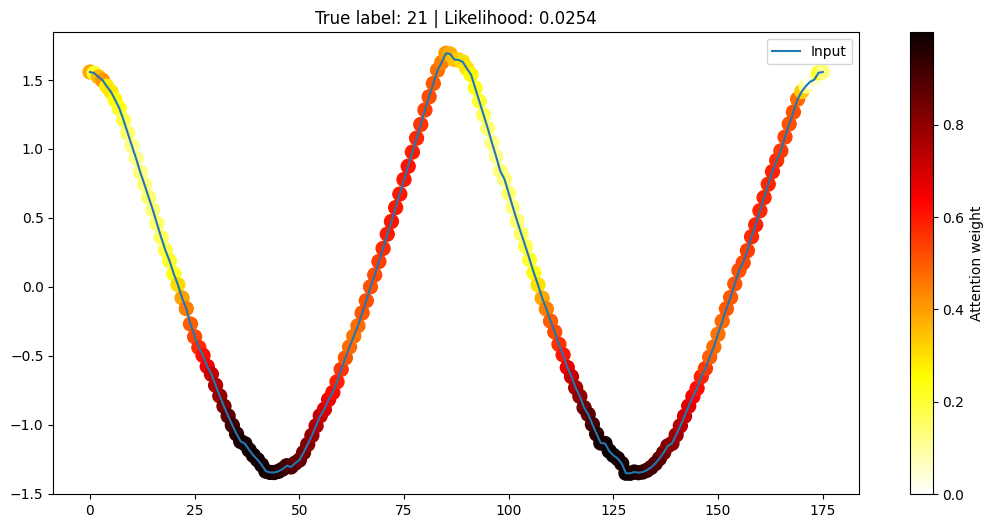

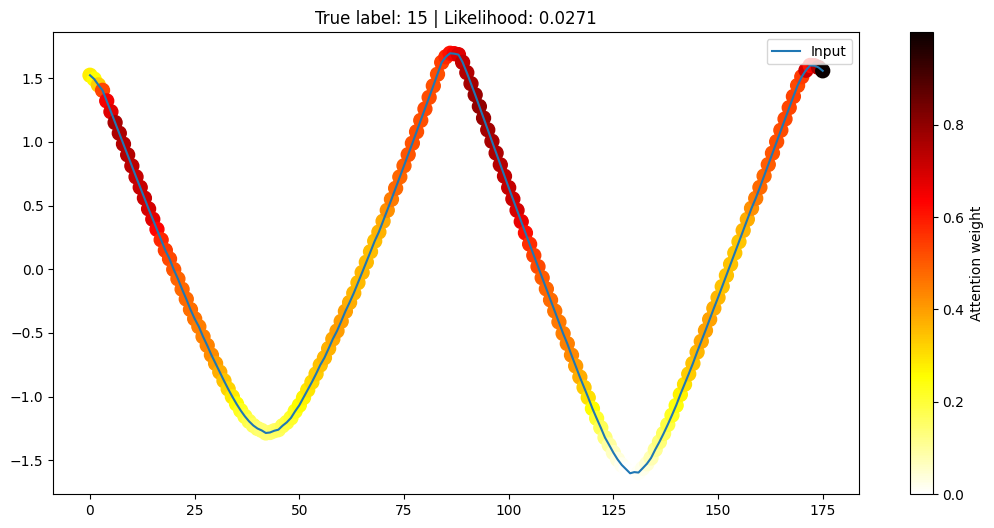

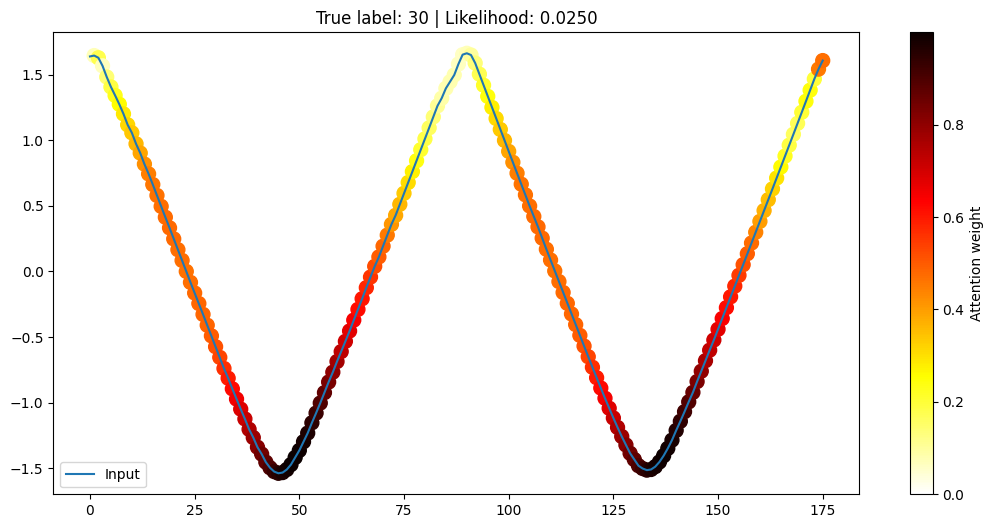

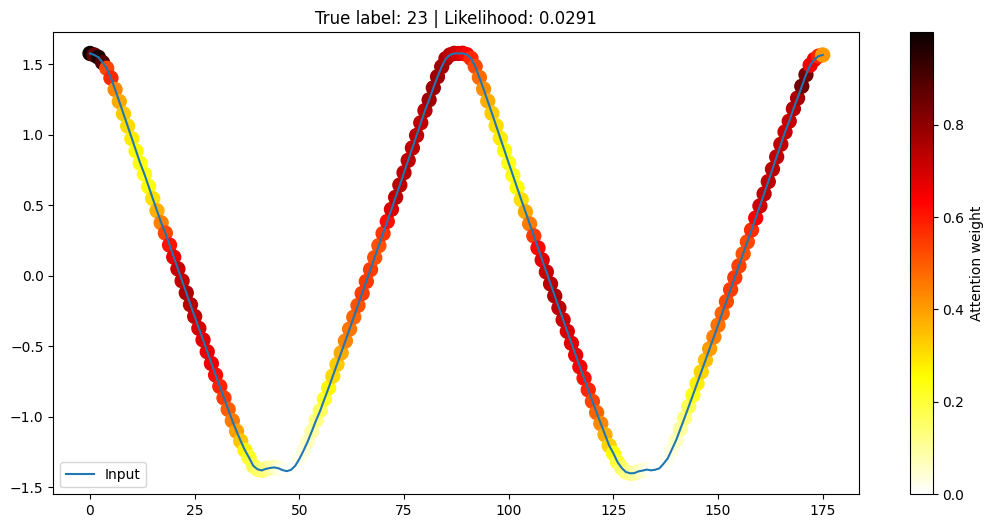

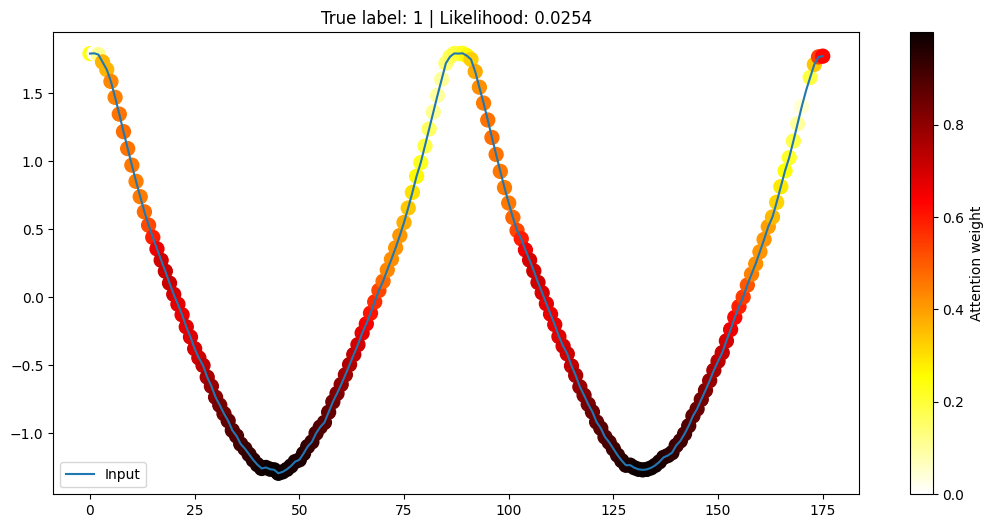

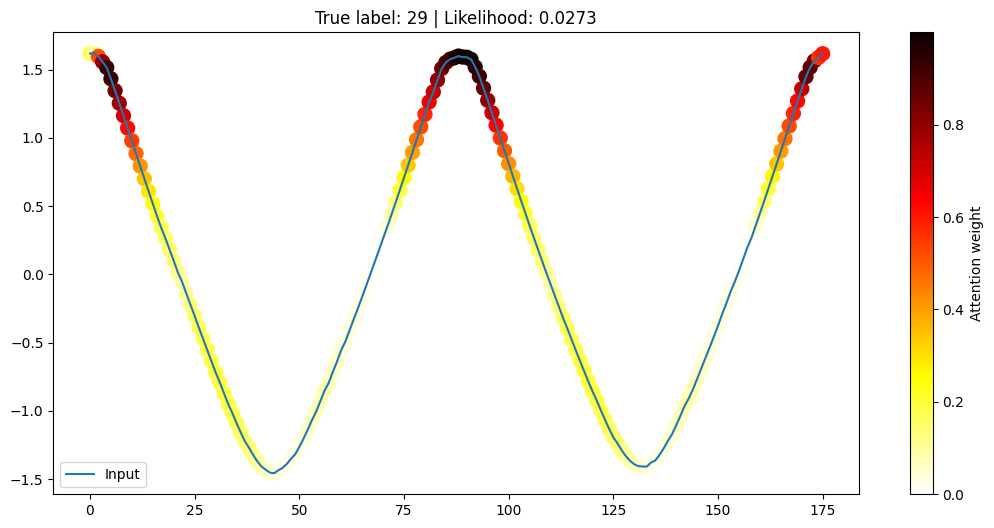

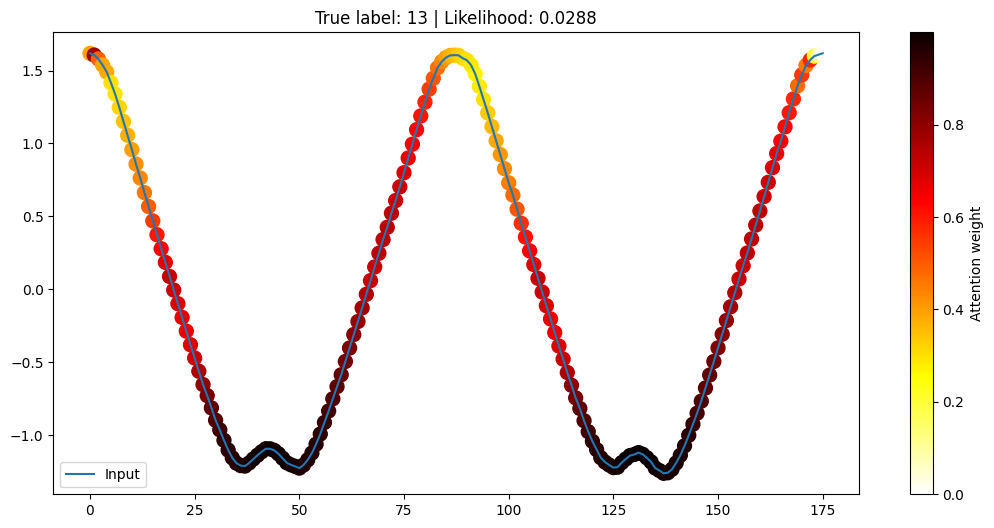

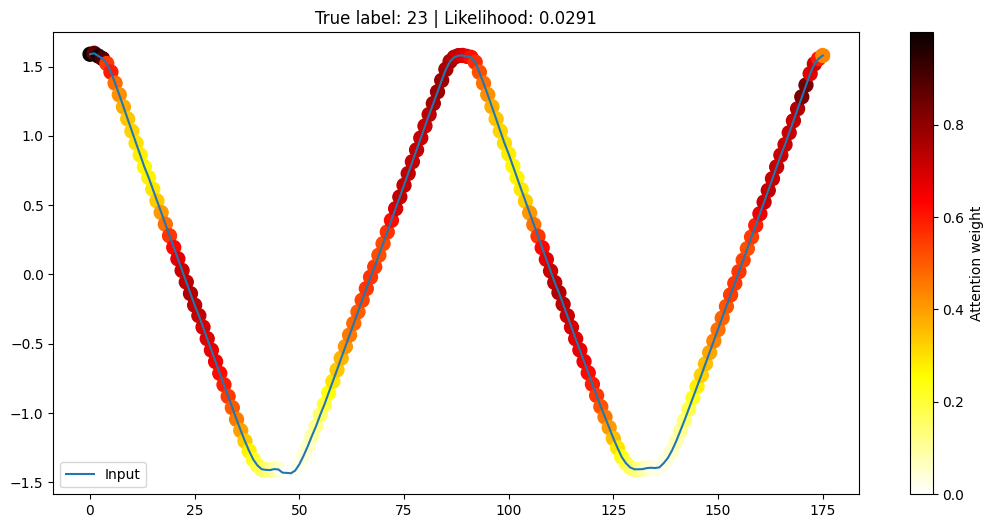

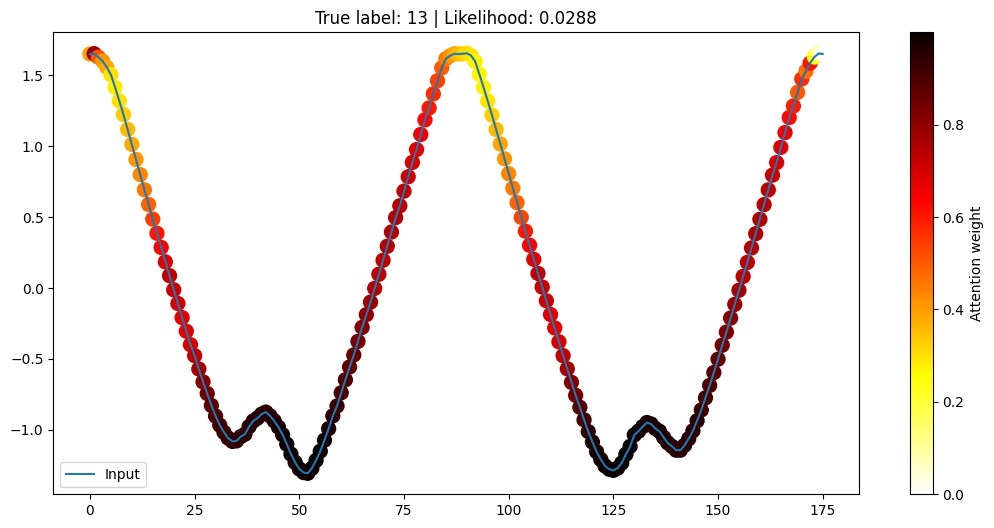

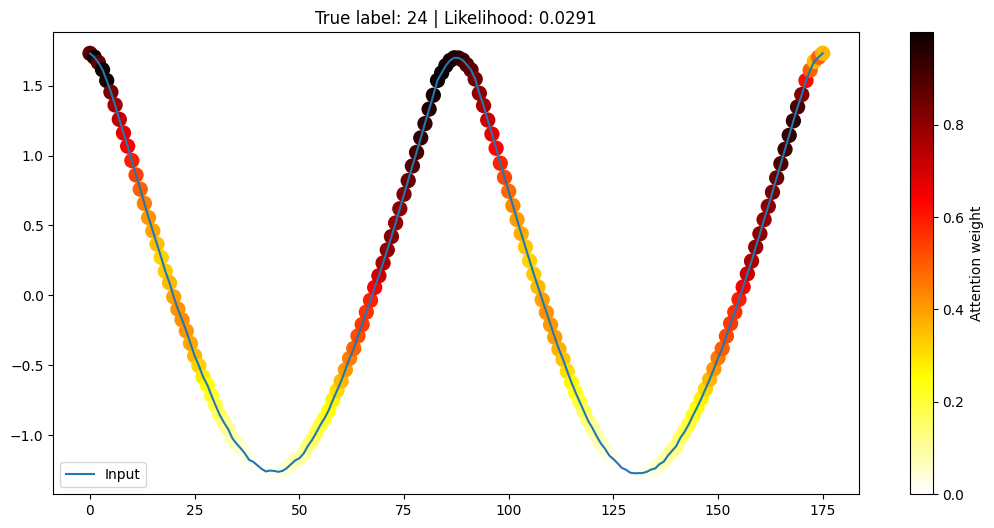

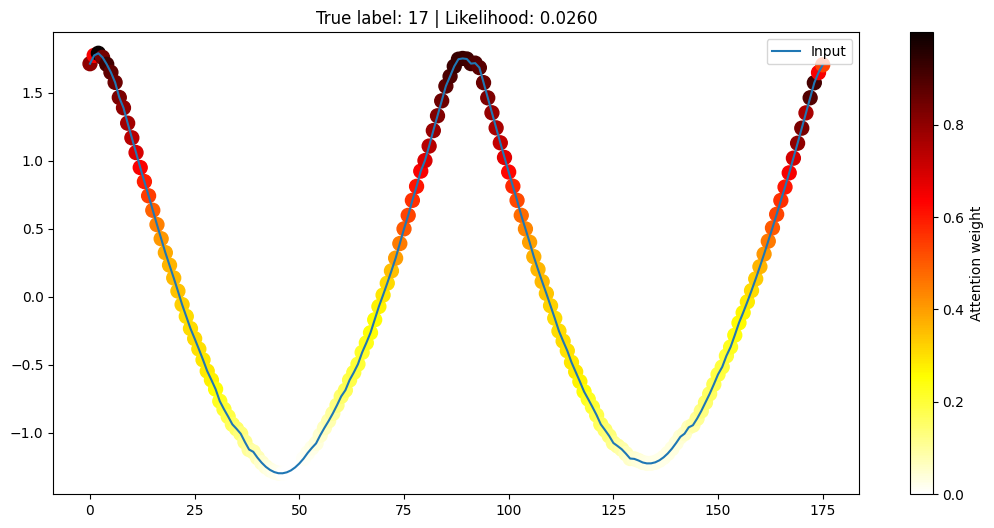

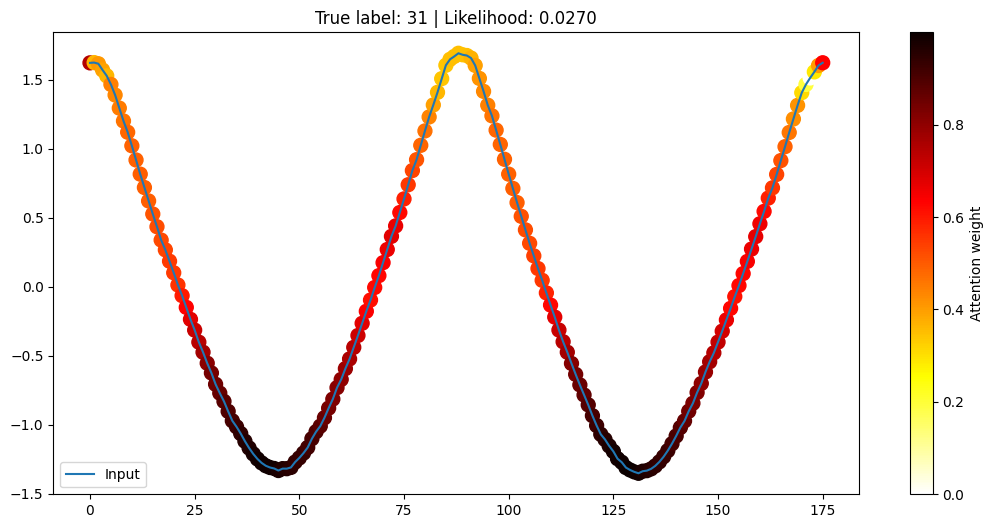

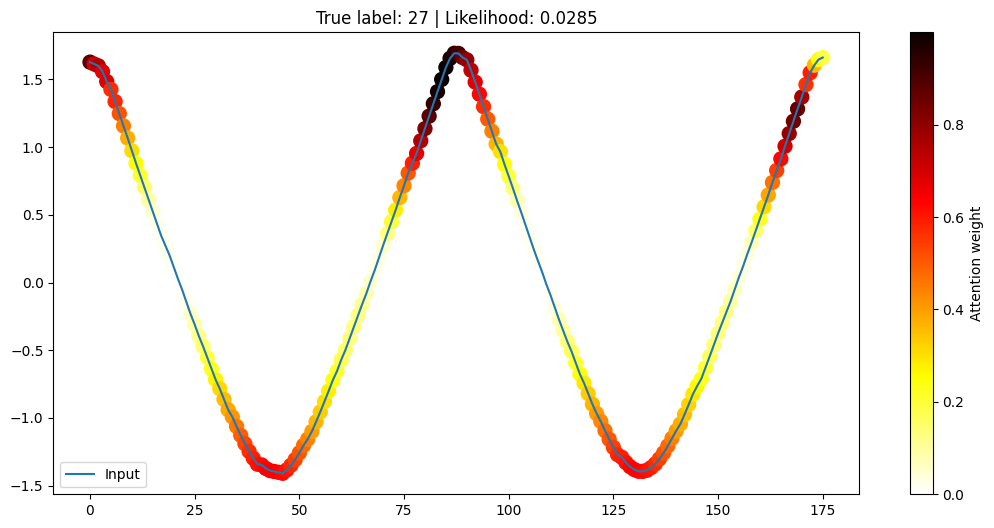

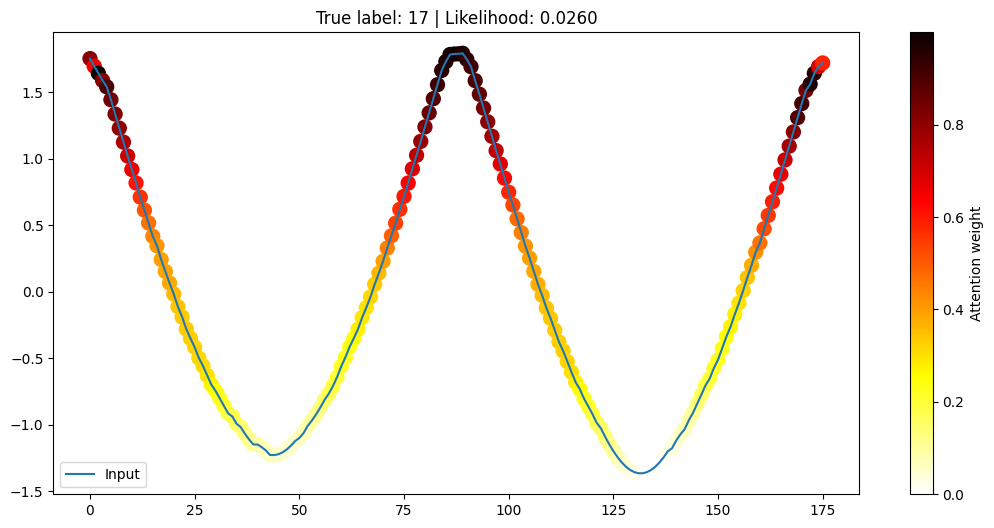

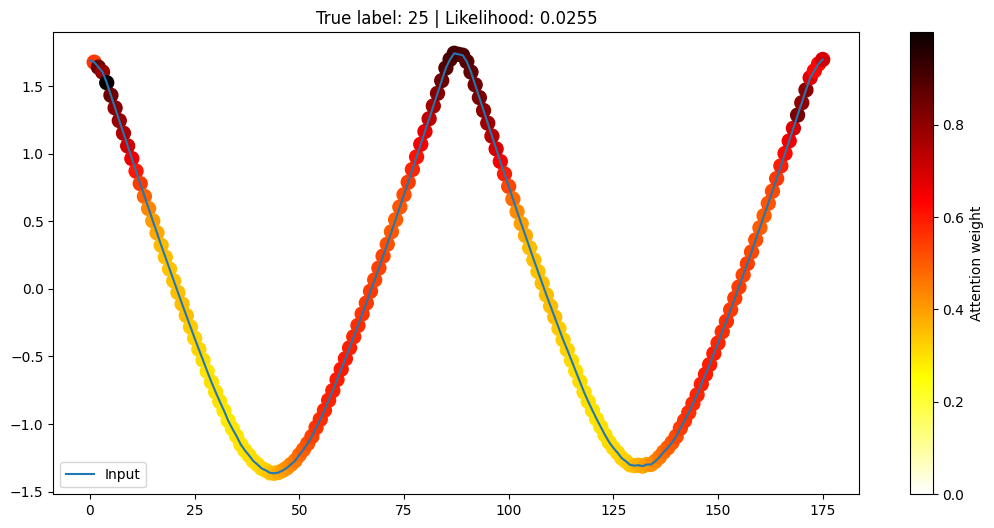

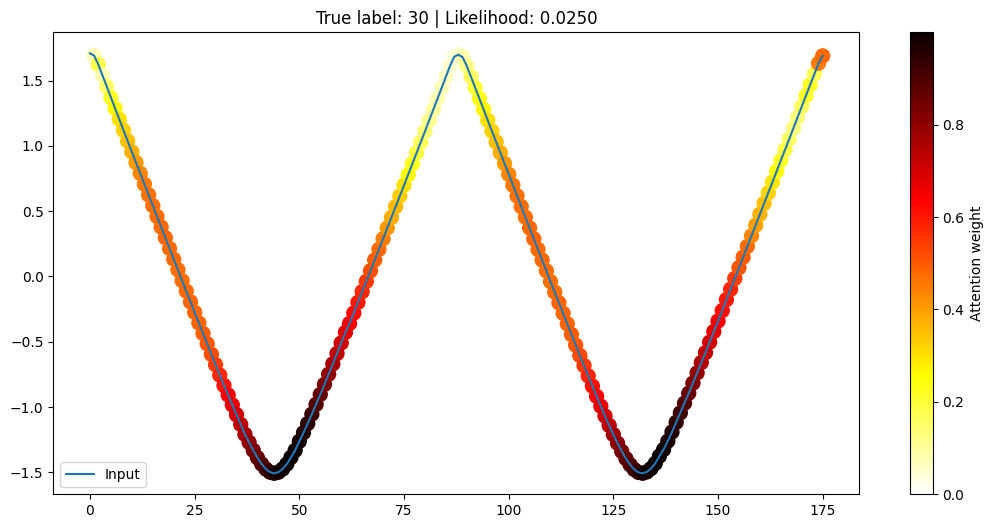

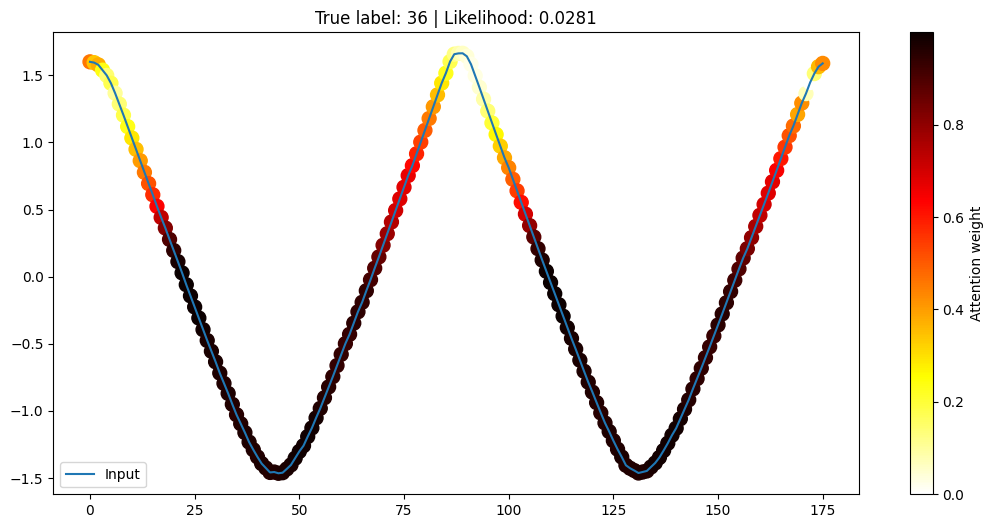

In [29]:
for k in range(20):
    true_class = y_test[k]
    class_likelihood = probs[k][true_class].item()

    plt.figure(figsize=(13, 6))
    plt.plot(input_test[k].squeeze().numpy(), label="Input")
    plt.scatter(np.arange(input_test.shape[-2]),
                input_test[k].squeeze().numpy(),
                c=CAM[k, :, true_class],
                cmap='hot_r',
                s=100)
    plt.title(f"True label: {true_class} | Likelihood: {class_likelihood:.4f}")
    plt.colorbar(label="Attention weight")
    plt.legend()
    plt.show()